In [2]:
#!pip install yfinance
#!pip install hmmlearn
#pip install scipy
from sklearn.mixture import GaussianMixture
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from scipy.stats import norm
import hmmlearn as hmm
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

In [4]:
ticker = "^GSPC"  # S&P 500 index symbol

data = yf.download(ticker, start="1996-11-01", end="2016-11-30", interval="1mo")
data.dropna(inplace=True)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-11-01,705.270020,762.119995,701.299988,757.020020,757.020020,8763850000
1996-12-01,757.020020,761.750000,716.690002,740.739990,740.739990,9089170000
1997-01-01,740.739990,794.669983,729.549988,786.159973,786.159973,11635830000
1997-02-01,786.159973,817.679993,773.429993,790.820007,790.820007,9715930000
1997-03-01,790.820007,814.900024,756.130005,757.119995,757.119995,10120760000
...,...,...,...,...,...,...
2016-07-01,2099.340088,2177.090088,2074.020020,2173.600098,2173.600098,69530250000
2016-08-01,2173.149902,2193.810059,2147.580078,2170.949951,2170.949951,75610310000
2016-09-01,2171.330078,2187.870117,2119.120117,2168.270020,2168.270020,77023620000


In [6]:
descriptive_stats = {
    "Price": ["Open", "High", "Low", "Close"],
    "Min": [data['Open'].min(), data['High'].min(), data['Low'].min(), data['Close'].min()],
    "Max": [data['Open'].max(), data['High'].max(), data['Low'].max(), data['Close'].max()],
    "Mean": [data['Open'].mean(), data['High'].mean(), data['Low'].mean(), data['Close'].mean()],
    "Std.": [data['Open'].std(), data['High'].std(), data['Low'].std(), data['Close'].std()],
}

summary_table = pd.DataFrame(descriptive_stats)
summary_table.to_csv('summary_table.csv', index=False, sep=';')
print("Summary_table.csv")
print(summary_table)

Summary_table.csv
   Price         Min          Max         Mean        Std.
0   Open  705.270020  2173.149902  1320.891532  354.761560
1   High  761.750000  2214.100098  1364.312162  355.196826
2    Low  666.789978  2147.580078  1273.670207  351.538327
3  Close  735.090027  2198.810059  1326.912735  356.909284


In [8]:
# Remove any rows with missing values
obs = data.dropna()

# Select the first four columns as observations
obs = obs[obs.columns[0:4]]
# Set the number of observations to consider for each iteration
T = 120

# Initialize empty lists to store the evaluation criteria results
AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = GaussianHMM(n_components=n, n_iter=120)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = GaussianHMM(n_components=n, init_params="c", n_iter=120)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(obs[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(obs[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

# Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

In [10]:
k

47

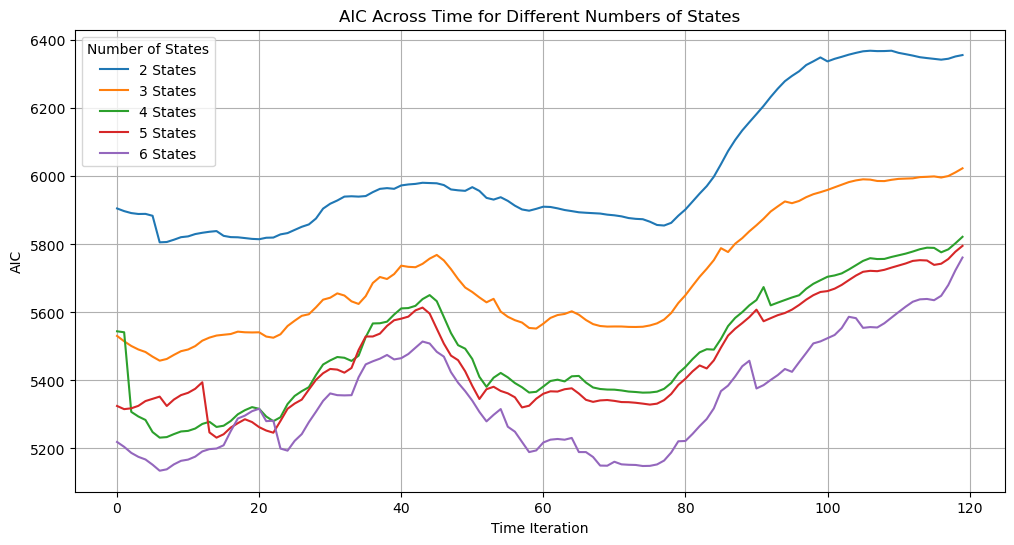

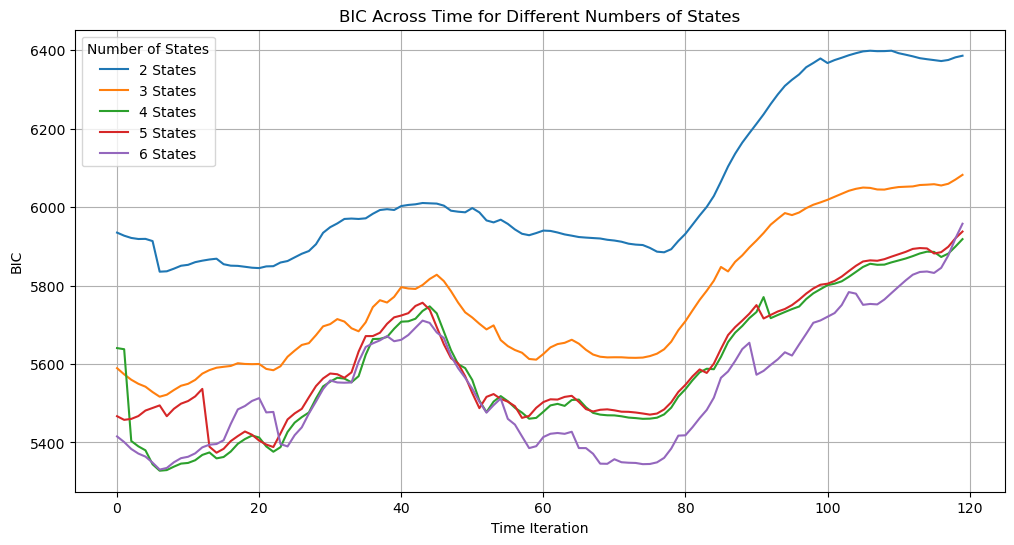

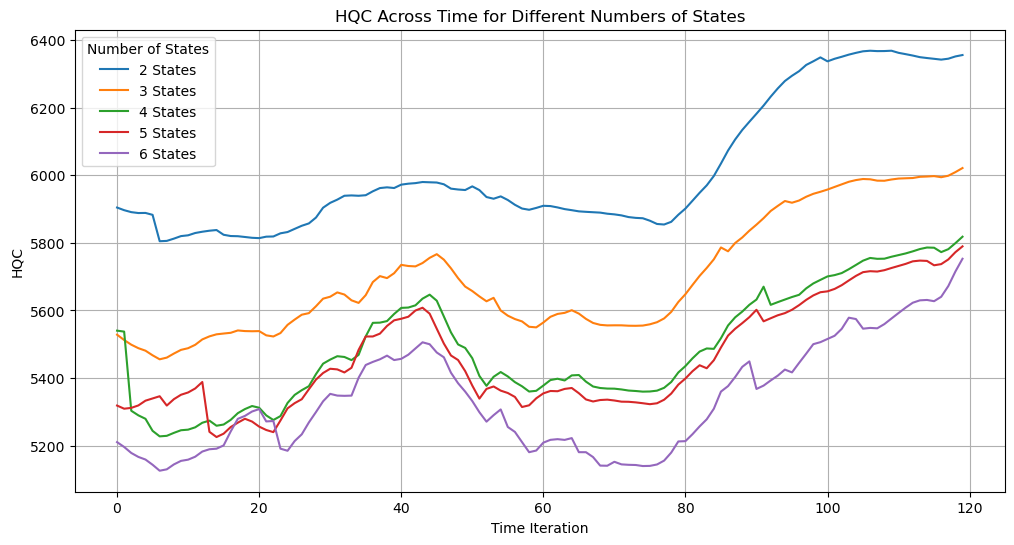

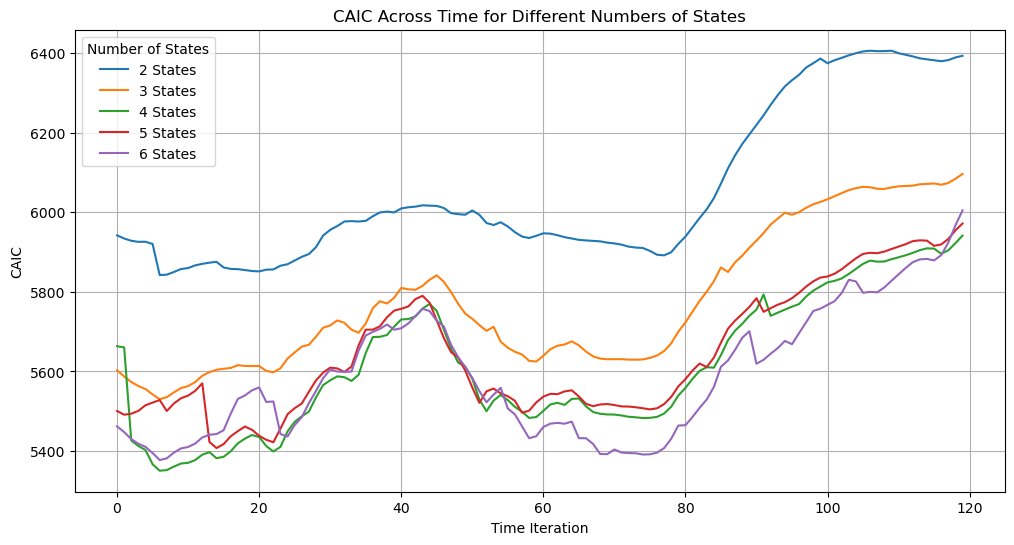

In [12]:
plt.figure(figsize=(12, 6))
num_states = range(2, 7)

for idx, aic_values in enumerate(AIC):
    plt.plot(aic_values, label=f"{num_states[idx]} States")
plt.title("AIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("AIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.show()

# Plot BIC across time for each number of states
plt.figure(figsize=(12, 6))
for idx, bic_values in enumerate(BIC):
    plt.plot(bic_values, label=f"{num_states[idx]} States")
plt.title("BIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("BIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.show()

# Plot HQC across time for each number of states
plt.figure(figsize=(12, 6))
for idx, hqc_values in enumerate(HQC):
    plt.plot(hqc_values, label=f"{num_states[idx]} States")
plt.title("HQC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("HQC")
plt.grid(True)
plt.legend(title="Number of States")
plt.show()

# Plot CAIC across time for each number of states
plt.figure(figsize=(12, 6))
for idx, caic_values in enumerate(CAIC):
    plt.plot(caic_values, label=f"{num_states[idx]} States")
plt.title("CAIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("CAIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.show()

In [ ]:
#need to do that only for T period of time 
#dont use the stack but just closing prices
#plot the result (which should 4 states)

#Model selection 
features = data['Close'].values
features = close.reshape(-1, 1)  # Reshape to a 2D array

close = np.column_stack([
    data['Open'].fillna(0),  # Percentage change of open price
    data['High'].fillna(0),  # Percentage change of high price
    data['Low'].fillna(0),   # Percentage change of low price
    data['Close'].fillna(0)  # Percentage change of close price
])

def calculate_model_criteria(hmm_model, M, k):  # M as number of obserations, k as number of parameters 
    L = model_gm.score(close)
    aic = -2 * L + 2 * k
    bic = -2 * L + k * np.log(M)
    hqc = -2 * L + 2 * k * np.log(np.log(M))
    caic = -2 * L + k * (1 + np.log(M))
    return {"AIC": aic, "BIC": bic, "HQC": hqc, "CAIC": caic}

state_range = range(2, 7)  # HMM with 2 to 6 states
data_length = len(close)

def res (obs, state_range):
    results = []
    for num_states in state_range:
        model_gm = GaussianMixture(n_components=num_states, covariance_type="diag", random_state=42)
        model_gm.fit(close)
        num_params = num_states ** 2 + 2 * num_states - 1 
        criteria = calculate_model_criteria(model_gm, data_length, num_params)
        results.append({"States": num_states, **criteria})
    return pd.DataFrame(results)

res_df = res(close, state_range)
print(res_df)

In [ ]:
# Step 6: Predict closing price
predicted_prices = []
har_model = data['Close'].rolling(window=10).mean().shift(1)

for i in range(len(close)):
    state = best_model.predict(close[:i + 1])[-1]  # Predict current state
    state_means = best_model.means_[state]            # Mean of observed values in the predicted state
    predicted_price = data['Close'].iloc[i] * (1 + state_means[-1])  # Predict close price based on % change
    predicted_prices.append(predicted_price)

In [ ]:
# Step 7: Evaluate predictions
data['Predicted_Close'] = predicted_prices
data['HAR_Close'] = har_model
data.dropna(inplace=True)

hmm_mse = mean_squared_error(data['Close'], data['Predicted_Close'])
har_mse = mean_squared_error(data['Close'], data['HAR_Close'])
print(f"HMM MSE: {hmm_mse}, HAR MSE: {har_mse}")

In [ ]:
# Step 8: Trading simulation (buy if predicted rise, sell otherwise)
data['Signal'] = np.where(data['Predicted_Close'] > data['Close'], 1, -1)
data['Return'] = data['Signal'] * data['Close'].pct_change()

hmm_cumulative_return = (1 + data['Return']).cumprod()
buy_and_hold_return = (1 + data['Close'].pct_change()).cumprod()

# Print results
print(f"HMM Cumulative Return: {hmm_cumulative_return.iloc[-1]:.2f}")
print(f"Buy-and-Hold Cumulative Return: {buy_and_hold_return.iloc[-1]:.2f}")